# Работа с датасетом Стенфордского университета

In [27]:
#Импортируем необходимые библиотеки для работы
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import time
import cv2

# Предварительный анализ датасета

In [28]:
df = pd.read_csv("./anno.csv", sep=";")
df

,Image,x1,y1,x2,y2,class,test
0,000001.jpg,112,7,853,717,1,0
1,000002.jpg,48,24,441,202,1,0
2,000003.jpg,7,4,277,180,1,0
3,000004.jpg,33,50,197,150,1,0
4,000005.jpg,5,8,83,58,1,0
...,...,...,...,...,...,...,...
16180,016181.jpg,38,36,375,234,196,1
16181,016182.jpg,29,34,235,164,196,1
16182,016183.jpg,25,32,587,359,196,1
16183,016184.jpg,56,60,208,186,196,1


Смотрим на распределение данных по классам

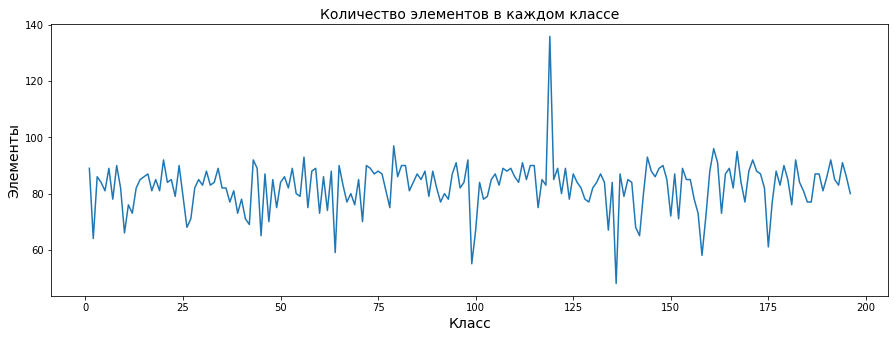

In [29]:
my_series = df.groupby("class")["Image"].count()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(my_series)
ax.set_title('Количество элементов в каждом классе', fontsize=14)
ax.set_xlabel('Класс', fontsize=14)
ax.set_ylabel('Элементы', fontsize=14)
plt.savefig('./img/image1.png')
plt.show()

Как можем заметить, классы не сбалансированы между собой

In [30]:
def get_box_plot_data(labels, bp):
    """Метод для красивой аналитики по ящику с усами"""
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

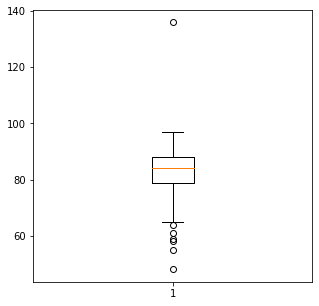

In [31]:
fig = plt.figure(figsize =(5, 5))
bp = plt.boxplot(my_series)
plt.savefig('./img/image2.png')
plt.show()

In [32]:
bp_df = get_box_plot_data(["bp"], bp)
bp_df

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,bp,65.0,78.75,84.0,88.0,97.0


Оставим только первые 12 классов по количеству элементов

In [33]:
buff_items = [(k,v) for k,v in my_series.to_dict().items()]
buff_items.sort(key=lambda x:x[1], reverse=True)
min_series_count = min([item[1] for item in buff_items[:6]])
min_series_count

93

In [34]:
new_series = my_series[my_series > min_series_count-1]
new_series

class
56      93
79      97
119    136
144     93
161     96
167     95
Name: Image, dtype: int64

Множество классов, которыке удовлетворяют условиям

In [35]:
classes_set = set(list(new_series.to_dict().keys()))
print(len(classes_set))

6


Формируем новый датасет, в который добавляем все новые классы

In [36]:
df_fixed = pd.DataFrame()

In [37]:
counter = 0
for item in classes_set:
    buf_df = df[df["class"] == item][:min_series_count]
    df_fixed = pd.concat([df_fixed, buf_df], ignore_index=True, sort=False)
    counter += 1
print(counter)

6


Заново строим график повому датаферйму df_fixed

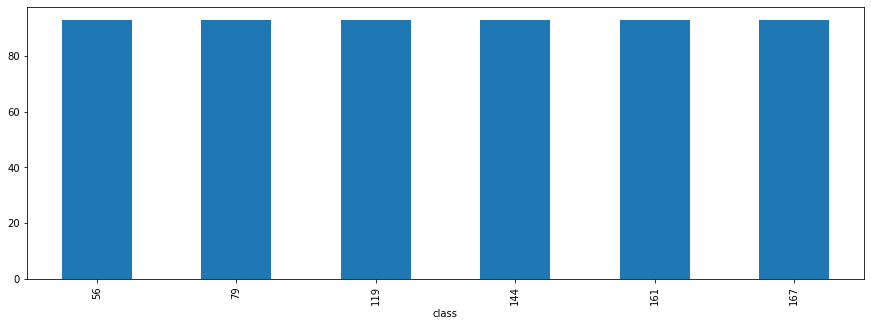

In [38]:
df_fixed.groupby("class")["Image"].count().plot(kind="bar",figsize=(15, 5))
plt.savefig('./img/image3.png')
plt.show()

Определяем список файлов, с которыми в дальнейшем будем работать

In [39]:
files_list = df_fixed["Image"].to_list()
files_len = len(files_list)
files_len

558

Определяем список классов, которые определяют эти файлы

In [40]:
CLASSES_DATA = df_fixed["class"].to_numpy()
print(len(df_fixed["class"].to_list()))
print(len(set(df_fixed["class"].to_list())))
CLASSES_DATA

558
6


array([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
       161, 161, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 16

# Загрузка и подготовка данных

In [41]:
row_number, column_number = 64, 64

In [42]:
all_files_list = df["Image"].to_list()

### 1. Переводим все изображения в формат матрицы

In [43]:
def patchfix(path: str) -> str:
     return f"./car_ims/{path}"

In [44]:
def show_img(index=0):
    plt.imshow(cv2.imread(patchfix(all_files_list[index]), cv2.IMREAD_UNCHANGED))

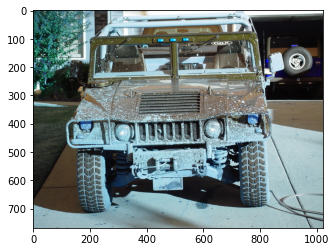

In [19]:
show_img()

### 2. Уменьшаем размеры

100/9072
200/9072
300/9072
400/9072
500/9072
600/9072
700/9072
800/9072
900/9072
1000/9072
1100/9072
1200/9072
1300/9072
1400/9072
1500/9072
1600/9072
1700/9072
1800/9072
1900/9072
2000/9072
2100/9072
2200/9072
2300/9072
2400/9072
2500/9072
2600/9072
2700/9072
2800/9072
2900/9072
3000/9072
3100/9072
3200/9072
3300/9072
3400/9072
3500/9072
3600/9072
3700/9072
3800/9072
3900/9072
4000/9072
4100/9072
4200/9072
4300/9072
4400/9072
4500/9072
4600/9072
4700/9072
4800/9072
4900/9072
5000/9072
5100/9072
5200/9072
5300/9072
5400/9072
5500/9072
5600/9072
5700/9072
5800/9072
5900/9072
6000/9072
6100/9072
6200/9072
6300/9072
6400/9072
6500/9072
6600/9072
6700/9072
6800/9072
6900/9072
7000/9072
7100/9072
7200/9072
7300/9072
7400/9072
7500/9072
7600/9072
7700/9072
7800/9072
7900/9072
8000/9072
8100/9072
8200/9072
8300/9072
8400/9072
8500/9072
8600/9072
8700/9072
8800/9072
8900/9072
9000/9072
9100/9072
9200/9072
9300/9072
9400/9072
9500/9072
9600/9072
9700/9072
9800/9072
9900/9072
10000/9072
10100/90

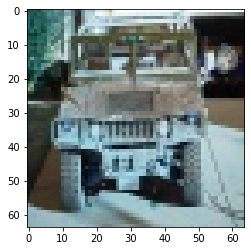

In [20]:
counter = 1
for file in all_files_list:
    img = cv2.imread(patchfix(file), cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, (row_number, column_number), interpolation = cv2.INTER_AREA)
    cv2.imwrite(patchfix(file), resized) 
    
    if counter % 100 == 0:
        print(f"{counter}/{files_len}")

    counter += 1
    
show_img()

### 3. Переводим в черно-белый формат

100/9072
200/9072
300/9072
400/9072
500/9072
600/9072
700/9072
800/9072
900/9072
1000/9072
1100/9072
1200/9072
1300/9072
1400/9072
1500/9072
1600/9072
1700/9072
1800/9072
1900/9072
2000/9072
2100/9072
2200/9072
2300/9072
2400/9072
2500/9072
2600/9072
2700/9072
2800/9072
2900/9072
3000/9072
3100/9072
3200/9072
3300/9072
3400/9072
3500/9072
3600/9072
3700/9072
3800/9072
3900/9072
4000/9072
4100/9072
4200/9072
4300/9072
4400/9072
4500/9072
4600/9072
4700/9072
4800/9072
4900/9072
5000/9072
5100/9072
5200/9072
5300/9072
5400/9072
5500/9072
5600/9072
5700/9072
5800/9072
5900/9072
6000/9072
6100/9072
6200/9072
6300/9072
6400/9072
6500/9072
6600/9072
6700/9072
6800/9072
6900/9072
7000/9072
7100/9072
7200/9072
7300/9072
7400/9072
7500/9072
7600/9072
7700/9072
7800/9072
7900/9072
8000/9072
8100/9072
8200/9072
8300/9072
8400/9072
8500/9072
8600/9072
8700/9072
8800/9072
8900/9072
9000/9072
9100/9072
9200/9072
9300/9072
9400/9072
9500/9072
9600/9072
9700/9072
9800/9072
9900/9072
10000/9072
10100/90

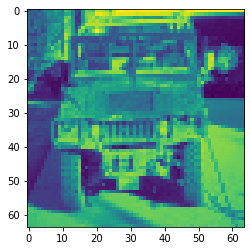

In [21]:
counter = 1
for file in all_files_list:
    img = cv2.imread(patchfix(file),cv2.IMREAD_UNCHANGED)

    
    #Если это RGB - конвертим
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    cv2.imwrite(patchfix(file), img) 
    
    if counter % 100 == 0:
        print(f"{counter}/{files_len}")
    
    counter += 1
    
show_img()

### 4. Формирование факторов

In [45]:
IMAGES_DATA = np.zeros(shape=(files_len,row_number*column_number))
IMAGES_DATA.shape

(558, 4096)

In [46]:
IMAGES_DATA

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
files_len = len(files_list)
for index, file in enumerate(files_list):
    img = cv2.imread(patchfix(file),cv2.IMREAD_UNCHANGED)
    IMAGES_DATA[index] = img.flatten()

In [48]:
IMAGES_DATA

array([[ 38.,  55.,  57., ..., 161., 163., 159.],
       [216., 217., 217., ..., 163., 158., 153.],
       [120.,  95.,  83., ..., 134., 133., 132.],
       ...,
       [185., 186., 188., ...,  81.,  82.,  83.],
       [ 13.,  10.,  25., ...,  54.,  64.,  82.],
       [137., 138., 139., ..., 105.,  97., 106.]])

Нормализация матриц

In [49]:
IMAGES_DATA = IMAGES_DATA / 255
IMAGES_DATA

array([[0.14901961, 0.21568627, 0.22352941, ..., 0.63137255, 0.63921569,
        0.62352941],
       [0.84705882, 0.85098039, 0.85098039, ..., 0.63921569, 0.61960784,
        0.6       ],
       [0.47058824, 0.37254902, 0.3254902 , ..., 0.5254902 , 0.52156863,
        0.51764706],
       ...,
       [0.7254902 , 0.72941176, 0.7372549 , ..., 0.31764706, 0.32156863,
        0.3254902 ],
       [0.05098039, 0.03921569, 0.09803922, ..., 0.21176471, 0.25098039,
        0.32156863],
       [0.5372549 , 0.54117647, 0.54509804, ..., 0.41176471, 0.38039216,
        0.41568627]])

## Работа в sklearn

Делим данные на тестовую и обучающую выборки

In [50]:
assert IMAGES_DATA.shape[0] == CLASSES_DATA.shape[0]

In [51]:
X = IMAGES_DATA
Y = CLASSES_DATA

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [53]:
# Реализация метода опорных векторов через SVC
from sklearn import svm

start_time = time.time()
nb = svm.SVC().fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.23      0.37      0.28        19
          79       0.57      0.63      0.60        19
         119       0.56      0.50      0.53        18
         144       0.50      0.16      0.24        19
         161       0.32      0.32      0.32        19
         167       0.11      0.11      0.11        18

    accuracy                           0.35       112
   macro avg       0.38      0.35      0.35       112
weighted avg       0.38      0.35      0.35       112

Время выполнения 1.0686569213867188


In [54]:
#Реализация наивного байесовского метода
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()
nb = MultinomialNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.18      0.16      0.17        19
          79       0.40      0.53      0.45        19
         119       0.39      0.39      0.39        18
         144       0.23      0.16      0.19        19
         161       0.26      0.42      0.32        19
         167       0.12      0.06      0.08        18

    accuracy                           0.29       112
   macro avg       0.26      0.28      0.27       112
weighted avg       0.26      0.29      0.27       112

Время выполнения 0.0548398494720459


In [55]:
# Реализация метода k-ближайших соседей
import sklearn.neighbors as neigh

start_time = time.time()
kn = neigh.KNeighborsClassifier(n_neighbors=90, n_jobs=6).fit(X_train,y_train)
y_pred = kn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.25      0.47      0.33        19
          79       0.39      0.47      0.43        19
         119       0.80      0.22      0.35        18
         144       0.50      0.05      0.10        19
         161       0.20      0.16      0.18        19
         167       0.16      0.28      0.20        18

    accuracy                           0.28       112
   macro avg       0.38      0.28      0.26       112
weighted avg       0.38      0.28      0.26       112

Время выполнения 0.1183779239654541


In [56]:
# Реализация метода опорных векторов через LinearSVC
import sklearn.svm as svm

start_time = time.time()
svect = svm.LinearSVC(max_iter=5000).fit(X_train, y_train)
y_pred = svect.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.14      0.16      0.15        19
          79       0.36      0.42      0.39        19
         119       0.21      0.22      0.22        18
         144       0.10      0.05      0.07        19
         161       0.24      0.21      0.22        19
         167       0.13      0.17      0.15        18

    accuracy                           0.21       112
   macro avg       0.20      0.21      0.20       112
weighted avg       0.20      0.21      0.20       112

Время выполнения 35.3028609752655


In [57]:
# Реализация логистической регресси
from sklearn.linear_model import LogisticRegression

start_time = time.time()
logr = LogisticRegression(max_iter=5000, n_jobs=6).fit(X_train, y_train)
y_pred = logr.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.10      0.11      0.10        19
          79       0.42      0.53      0.47        19
         119       0.31      0.28      0.29        18
         144       0.09      0.05      0.07        19
         161       0.24      0.21      0.22        19
         167       0.12      0.17      0.14        18

    accuracy                           0.22       112
   macro avg       0.21      0.22      0.22       112
weighted avg       0.21      0.22      0.22       112

Время выполнения 12.692738056182861


In [58]:
# Реализация метода случайного леса RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()
max_depth = [1,5,10,50]
n_estimators = [5,10,100,500]
grid_params ={'max_depth':max_depth,'n_estimators':n_estimators}
rf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_params,
                  scoring = 'accuracy', cv=10, n_jobs=6, return_train_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.18      0.32      0.23        19
          79       0.45      0.53      0.49        19
         119       0.67      0.44      0.53        18
         144       0.25      0.11      0.15        19
         161       0.32      0.32      0.32        19
         167       0.06      0.06      0.06        18

    accuracy                           0.29       112
   macro avg       0.32      0.29      0.30       112
weighted avg       0.32      0.29      0.30       112

Время выполнения 71.40646195411682


In [59]:
# Реализация линейного классификатора с SGD-обучением 
import math
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
grid_params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

sgd = GridSearchCV(SGDClassifier(class_weight= 'balanced'), grid_params, scoring = 'accuracy', cv=10, n_jobs=6, return_train_score=True)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          56       0.00      0.00      0.00        19
          79       0.00      0.00      0.00        19
         119       0.38      0.56      0.45        18
         144       0.00      0.00      0.00        19
         161       0.23      0.58      0.33        19
         167       0.16      0.33      0.22        18

    accuracy                           0.24       112
   macro avg       0.13      0.24      0.17       112
weighted avg       0.13      0.24      0.16       112

Время выполнения 32.73561191558838


/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# Зависимость точности от количества классов в датасете

In [84]:
classes_count_list = []
accurancy_list = []

In [85]:
from sklearn.naive_bayes import MultinomialNB

for i in range(1, 100):
    new_series1 = my_series[my_series > i]
    min_series_count1 = min(new_series1)
    classes_set1 = set(list(new_series1.to_dict().keys()))
    df_fixed1 = pd.DataFrame()
    
    for item in classes_set1:
        buf_df = df[df["class"] == item][:min_series_count1]
        df_fixed1 = pd.concat([df_fixed1, buf_df], ignore_index=True, sort=False)
    
    files_list1 = df_fixed1["Image"].to_list()
    files_len = len(files_list1)
    CLASSES_DATA = df_fixed1["class"].to_numpy()
    IMAGES_DATA = np.zeros(shape=(files_len,row_number*column_number))
    
    for index, file in enumerate(files_list1):
        img = cv2.imread(patchfix(file),cv2.IMREAD_UNCHANGED)
        IMAGES_DATA[index] = img.flatten()
    
    IMAGES_DATA = IMAGES_DATA / 255
    X = IMAGES_DATA
    Y = CLASSES_DATA
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
    
    nb = MultinomialNB().fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    acc = metrics.classification_report(y_test, y_pred, output_dict=True)["accuracy"]
    
    classes_count_list.append(len(classes_set1))
    accurancy_list.append(acc)

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [86]:
accurancy_list_fixed = [item *100 for item in accurancy_list]

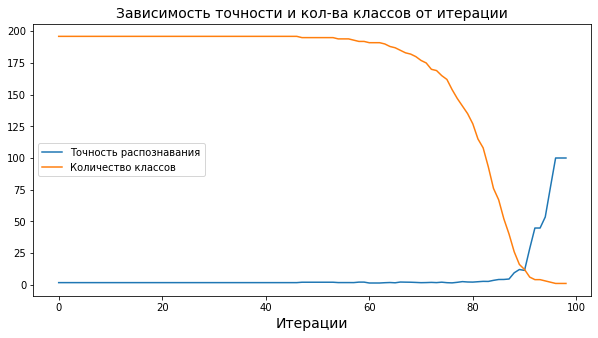

In [91]:
x = list(range(len(classes_count_list)))
y = accurancy_list_fixed
z = classes_count_list 

fig = plt.figure(figsize =(10, 5))
plt.plot(x, y, label='Точность распознавания')
plt.plot(x, z, label='Количество классов')

plt.title('Зависимость точности и кол-ва классов от итерации', fontsize=14)
plt.xlabel('Итерации', fontsize=14)

plt.legend()
plt.savefig('./img/problem1.png', bbox_inches='tight')
plt.show()

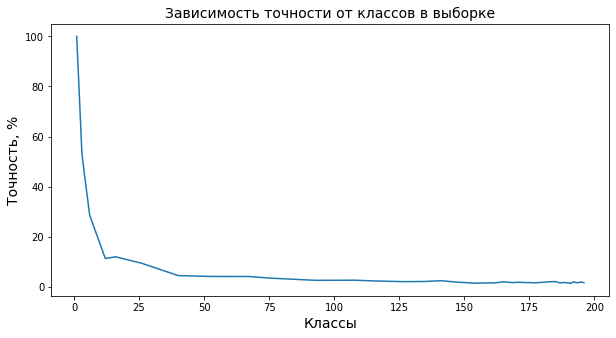

In [92]:
x = classes_count_list
y = accurancy_list_fixed

fig = plt.figure(figsize =(10, 5))
plt.plot(x, y, label='Точность распознавания')
plt.title('Зависимость точности от классов в выборке', fontsize=14)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Точность, %', fontsize=14)

plt.savefig('./img/problem2.png', bbox_inches='tight')
plt.show()